# Assignment 2: Deep Reinforcement Learning

## Overview

In this assignment, we will explore how to tackle sequential decision-making problems using reinforcement learning, without prior knowledge of the environment's dynamics. Specifically, we will try to learn to solve an instance of the Elevator environment. The Elevator environment models evening rush hours when people from different floors in a building want to go down to the bottom floor using elevators. Our goal is to develop an optimal policy for controlling the elevators to transport people efficiently to the ground floor.

We will employ deep reinforcement learning to discover the optimal policy, specifically using the Actor-Critic algorithm combined with Proximal Policy Optimization (PPO). Unlike standard policy gradient methods, the Actor-Critic framework learns both a policy (the actor) and a value function (the critic) concurrently. The critic enhances the efficiency of the policy improvement process by providing better bootstrap returns. To stabilize learning, we will utilize PPO for our objective function, which simplifies the concepts introduced in Trust Region Policy Optimization (TRPO) where it optimizes a surrogate objective while constraining policy updates with a KL divergence term. PPO employs a clipped surrogate objective to ensure that policy updates do not deviate excessively from the current policy [1],achieving results similar to those of TRPO while being much simpler to implement.

Throughout this assignment, you will build an Actor-Critic agent. You will implement both actor and critic networks using deep neural networks, deriving a stochastic policy from the actor network. Additionally, you will learn to implement key components of the Actor-Critic PPO training process, including calculating advantages and computing the PPO loss. This will involve defining the policy objective, value functions, and entropy components.

[1] Schulman, J., Wolski, F., Dhariwal, P., Radford, A., & Klimov, O. (2017). Proximal Policy Optimization Algorithms. arXiv preprint arXiv:1707.06347. <https://arxiv.org/abs/1707.06347>.

## Setup

### Installing Dependencies

The elevator task is implemented using the `PyRDDLGym` library. Before we begin, please install the following packages.

In [1]:
!pip install pyRDDLGym
!pip install rddlrepository

### Using Google Colab

If you are using Google Colab (and we encourage you to do so), please run the following code cell. If you are not using Google Colab, you can skip this code cell.

**Note**: The path `'/content/drive/'` cannot be changed. For example, if your assignment folder in Google Drive is located at `My Drive -> CSXX46A2`, you should specify the path as `'/content/drive/MyDrive/CSXX46A2'`.

In [2]:
# from google.colab import drive
# drive.mount('/content/drive/')

# import sys
# sys.path.append('/content/drive/MyDrive/CSXX46A2')

# %cd /content/drive/MyDrive/CSXX46A2

## Import Dependencies

In [3]:
import pyRDDLGym
from pyRDDLGym.core.env import RDDLEnv

from utils import DictToListWrapper, live_plot

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import random
import tqdm

from torch.distributions.categorical import Categorical

import gymnasium as gym
from gymnasium.wrappers import RecordEpisodeStatistics
from gymnasium.vector import SyncVectorEnv

## Environment

To ease environment creation in the subsequent steps, we define a function that returns an instance of the environment below. We will also include the `DictToListWrapper`, as we did in the `ElevatorEnv` notebook. Additionally, we will incorporate the `RecordEpisodeStatistics` wrapper to help track episode statistics.

In [4]:
def create_elevator_env():
    env = RDDLEnv(
        domain="selfDefinedEnvs/domain.rddl",
        instance="selfDefinedEnvs/instance5.rddl",  # instance-5 file
    )
    # If your observation is a Dict of booleans, flatten it:
    env = DictToListWrapper(env)
    env = RecordEpisodeStatistics(env)
    return env

### Vectorized Environments

To improve training efficiency and reduce the correlation between samples in a single sequence of experiences, we utilize multiple parallel environments to collect data. At each step, the agent interacts with $N$ environments simultaneously, storing the collected transitions in a rollout buffer. These transitions are then used to update the policy and value function.

We will use the `SyncVectorEnv` class to create multiple environments. Here, we set the number of parallel environments to 4.

**DO NOT MODIFY THE CODE BELOW**

In [5]:
NUM_ENVS = 4

envs = SyncVectorEnv([lambda: create_elevator_env() for _ in range(NUM_ENVS)])

/usr/local/lib/python3.12/dist-packages/pyRDDLGym/core/debug/exception.py:28: UserWarning: State invariant 1 does not have a structure of <action or state fluent> <op> <rhs>, where <op> is one of {<=, <, >=, >} and <rhs> is a deterministic function of non-fluents only, and will be ignored.
>> ( sum_{?f: floor} [ elevator-at-floor(?e, ?f) ] ) == 1
  warnings.warn(message)


Our vectorized environments have identical observation and action spaces, as shown below.

In [6]:
env = envs.envs[0].env
print(f"Observation space: {env.observation_space}")
env.get_state_description()

print(f"Action space: {env.action_space}")
env.get_action_description()

Observation space: Box(-inf, inf, (13,), float32)
State description:
state dim 0: num-person-waiting___f0
state dim 1: num-person-waiting___f1
state dim 2: num-person-waiting___f2
state dim 3: num-person-waiting___f3
state dim 4: num-person-waiting___f4
state dim 5: num-person-in-elevator___e0
state dim 6: elevator-dir-up___e0
state dim 7: elevator-closed___e0
state dim 8: elevator-at-floor___e0__f0
state dim 9: elevator-at-floor___e0__f1
state dim 10: elevator-at-floor___e0__f2
state dim 11: elevator-at-floor___e0__f3
state dim 12: elevator-at-floor___e0__f4
Action space: Discrete(6)
Action description:
Action 0: {'move-current-dir___e0': np.int64(0)}
Action 1: {'move-current-dir___e0': np.int64(1)}
Action 2: {'open-door___e0': np.int64(0)}
Action 3: {'open-door___e0': np.int64(1)}
Action 4: {'close-door___e0': np.int64(0)}
Action 5: {'close-door___e0': np.int64(1)}


## Hyperparameters

Here, we define the hyperparameters for the algorithm. The random seed is fixed to ensure reproducibility.

**DO NOT MODIFY THE CODE BELOW**

In [7]:
LEARNING_RATE = 2.5e-4

ROLLOUT_STEPS = 128
NUM_MINI_BATCHES = NUM_EPOCHS = 4
TOTAL_STEPS = 800000

GAMMA = 0.99
GAE_LAMBDA = 0.95

CLIP_COEF = 0.2
VALUE_LOSS_COEF = 0.5
ENTROPY_COEF = 0.01

# RANDOM SEED, DON'T MODIFY
SEED = 2048
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Helper Functions

In [8]:
def layer_init(layer, std=np.sqrt(2), bias_const=0.0):
    """Initialize the weights and biases of a layer.

    Args:
        layer (nn.Module): The layer to initialize.
        std (float): Standard deviation for orthogonal initialization.
        bias_const (float): Constant value for bias initialization.

    Returns:"
        nn.Module: The initialized layer.
    """
    torch.nn.init.orthogonal_(layer.weight, std)  # Orthogonal initialization
    torch.nn.init.constant_(layer.bias, bias_const)  # Constant bias
    return layer

## Actor-Critic Agent

The Actor-Critic agent is a type of reinforcement learning algorithm that combines two fundamental components: the **actor** and the **critic**.

- **Actor**: This part of the agent is responsible for determining which actions to take in a given state, effectively defining the policy. It maps states to action probabilities, allowing the agent to explore different actions based on learned strategies.

- **Critic**: The critic evaluates the action taken by the actor by estimating the value function, which represents the expected return (or future rewards) for a given state. This feedback helps the actor improve its policy over time.

By integrating both components, the Actor-Critic method benefits from the strengths of policy-based and value-based approaches, enabling more efficient learning in complex environments.

### Task 1: Implement the Actor-Critic Agent

In this task, you will complete a partially defined actor-critic agent template. Your implementation will involve the following components:

#### Task 1.1: Actor and Critic Networks

The actor-critic agent consists of two neural networks:

- **Actor Network**: This approximates the policy, mapping states to action probabilities (logits).
- **Critic Network**: This approximates the value function, mapping states to their corresponding value estimates.

You will need to specify the input and output dimensions for both the actor and critic networks:

- For the actor, define `actor_input_dim` and `actor_output_dim`.
- For the critic, define `critic_input_dim` and `critic_output_dim`.

These dimensions should be determined based on the specifics of your environment.

#### Task 1.2: Get Value

Implement the `get_value` function, which should return the values of given states by passing it through the critic network.

#### Task 1.3: Get Action Probabilities

Implement the `get_probs` function. This function should return the probability distribution over possible actions for a given state by using the actor network to compute logits. Since actions are discrete, you will use a categorical distribution for this.

**Hint**: Utilize the [`Categorical`](https://pytorch.org/docs/stable/distributions.html#categorical) class from `torch.distributions.categorical`.

#### Task 1.4: Get Action

Implement the `get_action` function to return an action sampled from the action probabilities obtained in the previous step. Remember, the actor-critic agent employs a stochastic policy.

#### Task 1.5: Get Log Probability of a Given Action

Implement the `get_action_logprob` function to return the log probability of a specified action based on the action probabilities generated earlier.

In [9]:
class ACAgent(nn.Module):
    """Actor-Critic agent using neural networks for policy and value function approximation."""

    def __init__(self):
        """Initialize the Actor-Critic agent with actor and critic networks."""
        super().__init__()

        ### ------------- TASK 1.1 ----------- ###
        ### ----- YOUR CODES START HERE ------ ###
        actor_input_dim = envs.single_observation_space.shape[0]      # Input dimension for the actor
        actor_output_dim = envs.single_action_space.n                 # Output dimension for the actor (number of actions)
        critic_input_dim = envs.single_observation_space.shape[0]     # Input dimension for the critic
        critic_output_dim = 1                                         # Output dimension for the critic (value estimate)
        ### ------ YOUR CODES END HERE ------- ###

        # Define the actor network
        self.actor = nn.Sequential(
            layer_init(nn.Linear(actor_input_dim, 64)),
            nn.Tanh(),
            layer_init(nn.Linear(64, 128)),
            nn.Tanh(),
            layer_init(nn.Linear(128, 64)),
            nn.Tanh(),
            layer_init(nn.Linear(64, actor_output_dim), std=0.01),  # Final layer with small std for output
        )

        # Define the critic network
        self.critic = nn.Sequential(
            layer_init(nn.Linear(critic_input_dim, 64)),
            nn.Tanh(),
            layer_init(nn.Linear(64, 128)),
            nn.Tanh(),
            layer_init(nn.Linear(128, 64)),
            nn.Tanh(),
            layer_init(nn.Linear(64, critic_output_dim), std=1.0),  # Standard output layer for value
        )

    def get_value(self, x):
        """Calculate the estimated value for a given state.

        Args:
            x (torch.Tensor): Input state, shape: (batch_size, observation_size)

        Returns:
            torch.Tensor: Estimated value for the state, shape: (batch_size, 1)
        """
        ### ------------- TASK 1.2 ----------- ###
        ### ----- YOUR CODES START HERE ------ ###
        value = self.critic(x)   # Forward pass through the critic network
        ### ------ YOUR CODES END HERE ------- ###
        return value

    def get_probs(self, x):
        """Calculate the action probabilities for a given state.

        Args:
            x (torch.Tensor): Input state, shape: (batch_size, observation_size)

        Returns:
            torch.distributions.Categorical: Categorical distribution over actions.
        """
        ### ------------- TASK 1.3 ----------- ###
        ### ----- YOUR CODES START HERE ------ ###
        logits = self.actor(x)  # Get logits from the actor network
        probs = Categorical(logits=logits)   # Create a categorical distribution from the logits
        ### ------ YOUR CODES END HERE ------- ###
        return probs

    def get_action(self, probs):
        """Sample an action from the action probabilities.

        Args:
            probs (torch.distributions.Categorical): Action probabilities.

        Returns:
            torch.Tensor: Sampled action, shape: (batch_size, 1)
        """
        ### ------------- TASK 1.4 ----------- ###
        ### ----- YOUR CODES START HERE ------ ###
        action = probs.sample()  # Sample an action based on the probabilities
        ### ------ YOUR CODES END HERE ------- ###
        return action

    def get_action_logprob(self, probs, action):
        """Compute the log probability of a given action.

        Args:
            probs (torch.distributions.Categorical): Action probabilities.
            action (torch.Tensor): Selected action, shape: (batch_size, 1)

        Returns:
            torch.Tensor: Log probability of the action, shape: (batch_size, 1)
        """
        ### ------------- TASK 1.5 ----------- ###
        ### ----- YOUR CODES START HERE ------ ###
        logprob = probs.log_prob(action)  # Calculate log probability of the sampled action
        ### ------ YOUR CODES END HERE ------- ###
        return logprob

    def get_entropy(self, probs):
        """Calculate the entropy of the action distribution.

        Args:
            probs (torch.distributions.Categorical): Action probabilities.

        Returns:
            torch.Tensor: Entropy of the distribution, shape: (batch_size, 1)
        """
        return probs.entropy()  # Return the entropy of the probabilities

    def get_action_logprob_entropy(self, x):
        """Get action, log probability, and entropy for a given state.

        Args:
            x (torch.Tensor): Input state.

        Returns:
            tuple: (action, logprob, entropy)
                - action (torch.Tensor): Sampled action.
                - logprob (torch.Tensor): Log probability of the action.
                - entropy (torch.Tensor): Entropy of the action distribution.
        """
        probs = self.get_probs(x)  # Get the action probabilities
        action = self.get_action(probs)  # Sample an action
        logprob = self.get_action_logprob(probs, action)  # Compute log probability of the action
        entropy = self.get_entropy(probs)  # Compute entropy of the action distribution
        return action, logprob, entropy  # Return action, log probability, and entropy

We can initialize our agent as follows.

In [10]:
agent = ACAgent().to(device)

We can do a sanity check for the agent implementation by executing the code below.

In [11]:
test_x = torch.zeros(10, envs.single_observation_space.shape[0], device=device)
test_probs = Categorical(F.one_hot(torch.arange(0, envs.single_action_space.n, device=device), num_classes=envs.single_action_space.n))
test_actions = torch.tensor([0, 1, 2, 3, 4, 5], device=device)
test_logprob = torch.tensor([-1.1921e-07, -1.1921e-07, -1.1921e-07, -1.1921e-07, -1.1921e-07, -1.1921e-07], device=device)

assert list(agent.get_value(test_x).shape) == [10, 1]
assert list(agent.get_probs(test_x).logits.shape) == [10, envs.single_action_space.n]
assert (agent.get_action(test_probs) == test_actions).all()
assert torch.allclose(agent.get_action_logprob(test_probs, test_actions), test_logprob)

## Actor-Critic Training with Proximal Policy Optimization (PPO)

Actor-critic training with Proximal Policy Optimization (PPO) is a powerful reinforcement learning framework that enhances both the stability and efficiency of policy learning.

### Training Process

1. **Rollout**: The agent interacts with the environment for a predefined number of steps, known as the rollout. During this phase, the actor selects actions based on its current policy, while the agent gathers states, actions, rewards, and other relevant information, which are stored in a rollout buffer. This collected data forms the basis for subsequent policy and value updates.

2. **Advantage Estimation**: After completing the rollout, the agent computes advantages using the Generalized Advantage Estimation (GAE) method. This technique produces stable and low-variance estimates of the advantage function, indicating how much better or worse an action performed compared to the expected return. GAE improves learning efficiency by providing more accurate feedback for policy updates.

3. **Updating Actor and Critic**:

   - **Policy Update**: The actor's policy is refined using the computed advantages. PPO employs a clipped surrogate objective to limit the magnitude of policy updates, ensuring that changes remain within a safe range. This clipping mechanism fosters stable learning and reduces the risk of drastic performance drops.

   - **Value Update**: The critic's value function is updated to minimize the difference between predicted values and actual returns, typically using mean squared error (MSE) loss. This adjustment allows the critic to provide reliable feedback to the actor, enhancing the overall learning process.

   - **Entropy Regularization**: To promote exploration, PPO includes an entropy term in its objective function. This term discourages certainty in action selection, encouraging the agent to explore a wider range of actions and preventing premature convergence on suboptimal policies.

### Rollout

#### Rollout Buffer

In the rollout buffer, we gather experiences from the environment over a defined number of steps, known as `ROLLOUT_STEPS`. These experiences are then used to update the agent’s policy and value function. Once the update is complete, the experiences in the buffer are discarded. This method contrasts with the DQN algorithm, which retains and reuses transitions from a replay buffer for multiple updates.

The rollout buffer captures a variety of information essential for updating the agent, including:

- **States**: The states encountered by the agent.
- **Actions**: The actions taken by the agent in each state.
- **Rewards**: The rewards received after taking those actions.
- **Done Flags**: Indicators of whether an episode has ended.
- **Log Probabilities**: The log probabilities of the actions taken, as determined by the actor.
- **Values**: The value estimates for the states from the critic.

Given that we have `NUM_ENVS` parallel environments, the shape of the rollout buffer will be structured as `(ROLLOUT_STEPS, NUM_ENVS)`. This allows us to efficiently gather and store data from multiple environments simultaneously, facilitating more robust training and improved sample efficiency.

In [12]:
states = torch.zeros((ROLLOUT_STEPS, NUM_ENVS) + envs.single_observation_space.shape).to(device)
actions = torch.zeros((ROLLOUT_STEPS, NUM_ENVS) + envs.single_action_space.shape).to(device)
rewards = torch.zeros((ROLLOUT_STEPS, NUM_ENVS)).to(device)
dones = torch.zeros((ROLLOUT_STEPS, NUM_ENVS)).to(device)

logprobs = torch.zeros((ROLLOUT_STEPS, NUM_ENVS)).to(device)
values = torch.zeros((ROLLOUT_STEPS, NUM_ENVS)).to(device)

#### Reward Normalization

To stabilize and improve the training process in reinforcement learning, we sometimes adjust and scales the rewards received by the agent to ensure that they remain within a consistent range. Common methods for reward normalization include standardization (subtracting the mean and dividing by the standard deviation) or min-max scaling (rescaling rewards to a specified range).

Here, we compute the minimum and maximum rewards of the environment, which we will later use for min-max scaling of the rewards.

In [13]:
floors = 5
max_waiting = 3
max_in_ele = 10
in_ele_penalty = 0.75
people_waiting_penalty = 3.0
reward_delivered = 30

min_reward = - in_ele_penalty * max_in_ele - people_waiting_penalty * max_waiting * floors
max_reward = max_in_ele * reward_delivered

print("Minimum reward:", min_reward)
print("Maximum reward:", max_reward)

Minimum reward: -52.5
Maximum reward: 300


#### Batch, Mini Batch, and Iterations

After completing a rollout of length $T$ across $N$ parallel environments, we obtain one batch of data with a size of $T \times N$. This total represents the batch size. We train the actor-critic agent using this batch by splitting the data into minibatches and training for $E$ epochs.

The total number of iterations or updates is calculated by dividing the total number of interaction steps by the batch size.

**Note:** The batch size mentioned here refers specifically to the rollout batch size. In the code implementation, we use `batch_size` to denote the number of batched inputs/outputs/data, which may differ from the rollout batch size.

In [14]:
BATCH_SIZE = ROLLOUT_STEPS * NUM_ENVS
MINI_BATCH_SIZE = BATCH_SIZE // NUM_MINI_BATCHES
NUM_ITERATIONS = TOTAL_STEPS // BATCH_SIZE

### Task 2: Computing the Advantages

The standard advantage formulation is defined as:

$$
A(s,a) = Q(s,a) - V(s) = r_t + \gamma V(s') - V(s)
$$

In Proximal Policy Optimization (PPO), we use Generalized Advantage Estimation (GAE), which is computed as follows:

$$
\hat{A}_t = \delta_t + (\gamma \lambda) \hat{A}_{t+1}
$$

Expanding this, we have:

$$
\hat{A}_t = \delta_t + (\gamma \lambda) \delta_{t+1} + (\gamma \lambda)^2 \delta_{t+2} + \ldots + (\gamma \lambda)^{T-t-1} \delta_{T-1}
$$

where

$$
\delta_t = r_t + \gamma V(s_{t+1}) - V(s_t)
$$

The advantage calculation is based on the $TD(\lambda)$ method, which extends the standard formulation by considering multiple time steps. This allows us to smooth over future rewards using the discount factor $\gamma$ and a decay factor $\lambda$ (known as the Generalized Advantage Estimation factor).

The essence of GAE is to weigh the TD errors $\delta_t$ at each time step and accumulate them for a more accurate advantage estimate.

In practice, the $TD(\lambda)$ advantage is computed iteratively, starting with the immediate TD error $\delta_t = r_t + \gamma V(s_{t+1}) - V(s_t)$, and recursively adding future TD errors weighted by $ \gamma\lambda$. This approach effectively captures the influence of future rewards in a flexible manner.

In this task, you'll be implementing the $\delta_t$, which is essential for the GAE computation.

**Hint**: Remember to use the `next_nonterminal` variable to handle terminal states appropriately.

In [15]:
def get_deltas(rewards, values, next_values, next_nonterminal, gamma):
    """Compute the temporal difference (TD) error.

    Args:
        rewards (torch.Tensor): Rewards at each time step, shape: (batch_size,).
        values (torch.Tensor): Predicted values for each state, shape: (batch_size,).
        next_values (torch.Tensor): Predicted value for the next state, shape: (batch_size,).
        gamma (float): Discount factor.

    Returns:
        torch.Tensor: Computed TD errors, shape: (batch_size,).
    """
    ### -------------- TASK 2 ------------ ###
    ### ----- YOUR CODES START HERE ------ ###
    deltas = rewards + gamma * next_values * next_nonterminal - values
    ### ------ YOUR CODES END HERE ------- ###
    return deltas

In [16]:
# Test get_deltas
dummy_rewards = torch.ones(3)
dummy_values = torch.tensor([4,5,6])
dummy_next_values = torch.arange(3)
dummy_next_nonterminal = torch.tensor([1,0,1])
dummy_deltas = torch.tensor([-3., -4., -4.8])
assert torch.allclose(get_deltas(dummy_rewards, dummy_values, dummy_next_values, dummy_next_nonterminal, gamma=0.1), dummy_deltas)

### Task 3: Updating the Actor and Critic Networks

After computing the advantages and returns, we shuffle the rollout data and divide the data into mini-batches. We then use the mini-batches to update the actor and critic networks.

#### Task 3.1: Compute the Surrogate Policy Objective

The policy objective is defined using the following clipped surrogate objective:

$$
J^{CLIP}(\theta) = \hat{\mathbb{E}}_t \left[ \min \left( r_t(\theta) \hat{A}_t, \text{clip}(r_t(\theta), 1 - \epsilon, 1 + \epsilon) \hat{A}_t \right) \right]
$$

Here, $\hat{A}_t$ is the advantage estimates and $r_t(\theta) = \frac{\pi_\theta(a_t|s_t)}{\pi_{\theta_\text{old}}(a_t|s_t)}$ represents the probability ratio between the new policy and the old policy.

You will need to implement the `get_ratio` and `get_policy_objective` functions:

- **Task 3.1.1**: `get_ratio`: This function should compute the probability ratio $r_t(\theta)$. To improve numerical stability and avoid issues arising from division by small numbers, rewrite the equation as follows:
  $$
  r_t(\theta) = \exp\left( \log\left( \frac{\pi_\theta(a_t|s_t)}{\pi_{\theta_\text{old}}(a_t|s_t)} \right) \right) = \exp\left( \log(\pi_\theta(a_t|s_t)) - \log(\pi_{\theta_\text{old}}(a_t|s_t)) \right)
  $$

- **Task 3.1.2**: `get_policy_objective`: This function should compute the value of $J^{CLIP}(\theta)$ using the results from `get_ratio` and the advantage estimates $\hat{A}_t$.

In [17]:
def get_ratio(logprob, logprob_old):
    """Compute the probability ratio between the new and old policies.

    This function calculates the ratio of the probabilities of actions under
    the current policy compared to the old policy, using their logarithmic values.

    Args:
        logprob (torch.Tensor): Log probability of the action under the current policy,
                                shape: (batch_size,).
        logprob_old (torch.Tensor): Log probability of the action under the old policy,
                                    shape: (batch_size,).

    Returns:
        torch.Tensor: The probability ratio of the new policy to the old policy,
                      shape: (batch_size,).
    """
    ### ------------ TASK 3.1.1 ---------- ###
    ### ----- YOUR CODES START HERE ------ ###
    logratio = torch.clamp(logprob - logprob_old, -20.0, 20.0)  # Compute the log ratio
    ratio = torch.exp(logratio)  # Exponentiate to get the probability ratio
    ### ------ YOUR CODES END HERE ------- ###
    return ratio

In [18]:
# Test get_ratio
dummy_logprob = torch.tensor([0.1, 0.9])
dummy_logprob_old = torch.tensor([0.5, 0.1])
dummy_ratio = torch.tensor([0.6703, 2.2255])
assert torch.allclose(get_ratio(dummy_logprob, dummy_logprob_old), dummy_ratio, rtol=1e-4)

In [21]:
def get_policy_objective(advantages, ratio, clip_coeff=CLIP_COEF):
    """Compute the clipped surrogate policy objective.

    This function calculates the policy objective using the advantages and the
    probability ratio, applying clipping to stabilize training.

    Args:
        advantages (torch.Tensor): The advantage estimates, shape: (batch_size,).
        ratio (torch.Tensor): The probability ratio of the new policy to the old policy,
                             shape: (batch_size,).
        clip_coeff (float, optional): The clipping coefficient for the policy objective.
                                       Defaults to CLIP_COEF.

    Returns:
        torch.Tensor: The computed policy objective, a scalar value.
    """
    ### ------------ TASK 3.1.2 ---------- ###
    ### ----- YOUR CODES START HERE ------ ###
    policy_objective1 = ratio * advantages  # Calculate the first policy loss term
    policy_objective2 = torch.clamp(ratio, 1 - clip_coeff, 1 + clip_coeff) * advantages  # Calculate the clipped policy loss term
    policy_objective = torch.mean(torch.min(policy_objective1, policy_objective2))  # Take the minimum and average over the batch
    ### ------ YOUR CODES END HERE ------- ###
    return policy_objective

In [22]:
# Test get_policy_objective
dummy_advantages = torch.arange(2).float()
assert np.allclose(get_policy_objective(dummy_advantages, dummy_ratio).item(), 0.6)

#### Task 3.2: Compute the Value Loss

The value loss is calculated as the mean squared error (MSE) between the predicted value and the computed return:

$$
L^{VF}(\theta)_{ori} = \hat{\mathbb{E}}_t \left[ \frac{1}{2} \left( V(s_t) - {Return}_t \right)^2 \right]
$$

To improve stability during training, we also use a clipped version of the value loss, defined as:

$$
L^{VF}(\theta)_{clip} = \hat{\mathbb{E}}_t \left[ \frac{1}{2} \left( \text{clip}(V_{\theta_t}(s_t), V_{\theta_{t-1}}(s_t) - \epsilon, V_{\theta_{t-1}}(s_t) + \epsilon) - {Return}_t \right)^2 \right]
$$

It can also be written as:
$$
L^{VF}(\theta)_{clip} = \hat{\mathbb{E}}_t \left[ \frac{1}{2} \left( V_{\theta_{t-1}}(s_t) + \text{clip}(V_{\theta_t}(s_t) - V_{\theta_{t-1}}(s_t),  - \epsilon, + \epsilon) - {Return}_t \right)^2 \right]
$$


The final value loss is determined by taking the maximum of the two value losses:

$$
L^{VF}(\theta) = \max(L^{VF}(\theta)_{ori}, L^{VF}(\theta)_{clip})
$$

Implement the value loss $L^{VF}(\theta)$ below.

In [23]:
def get_value_loss(values, values_old, returns):
    """Compute the combined value loss with clipping.

    This function calculates the unclipped and clipped value losses
    and returns the maximum of the two to stabilize training.

    Args:
        values (torch.Tensor): Predicted values from the critic, shape: (batch_size, 1).
        values_old (torch.Tensor): Old predicted values from the critic, shape: (batch_size, 1).
        returns (torch.Tensor): Computed returns for the corresponding states, shape: (batch_size, 1).

    Returns:
        torch.Tensor: The combined value loss, a scalar value.
    """
    ### ------------- TASK 3.2 ----------- ###
    ### ----- YOUR CODES START HERE ------ ###
    values   = values.view(-1)
    returns  = returns.view(-1)
    values_old = values_old.view(-1)

    value_loss_unclipped = (values - returns).pow(2)  # Calculate unclipped value loss

    values_clipped = values_old + torch.clamp(values - values_old, -CLIP_COEF, CLIP_COEF)
    value_loss_clipped = (values_clipped - returns).pow(2)  # Calculate clipped value loss

    value_loss = 0.5 * torch.mean(torch.max(value_loss_unclipped, value_loss_clipped))  # Average over the batch
    ### ------ YOUR CODES END HERE ------- ###
    return value_loss  # Return the final combined value loss

In [24]:
# Test get_value_loss
dummy_values = torch.tensor([1,2,3]).float()
dummy_values_old = torch.tensor([4,5,6]).float()
dummy_returns = torch.tensor([7,8,9]).float()
assert np.allclose(get_value_loss(dummy_values, dummy_values_old, dummy_returns).item(), 18)

#### Compute Entropy Objective

The entropy measures the randomness of the policy's action distribution. By maximizing entropy, we encourage exploration, helping the agent avoid premature convergence to suboptimal strategies. The entropy objective can be computed using the following formula:

$$
H(\theta) = - \mathbb{E}_{s_t} \left[ \sum_{a} \pi_\theta(a|s_t) \log(\pi_\theta(a|s_t)) \right]
$$

The implementation of the entropy objective is given below.

In [25]:
def get_entropy_objective(entropy):
    """Compute the entropy objective.

    This function calculates the average entropy of the action distribution,
    which encourages exploration by penalizing certainty.

    Args:
        entropy (torch.Tensor): Entropy values for the action distribution, shape: (batch_size,).

    Returns:
        torch.Tensor: The computed entropy objective, a scalar value.
    """
    return entropy.mean()  # Return the average entropy

#### Task 3.3: Compute the Total Loss

To compute the total loss, we aim to:

1. **Maximize the Policy Objective**: This allows the policy to perform better, i.e., gives higher expected returns.

2. **Minimize Value Loss**: This helps ensure that the value function accurately estimates future rewards (utility).

3. **Maximize Entropy**: This promotes exploration by encouraging the agent to try a variety of actions rather than exploiting known strategies.

To implement these objectives using gradient descent, we can transform the maximization of the policy/entropy objective into a minimization problem by minimizing the negative of the objective (i.e., minimizing the policy/entropy loss).

In summary, the total loss can be formulated as:

$$
J^{PPO}(\theta) = -J^{CLIP}(\theta) + c_1 L^{VF}(\theta) - c_2 H(\theta)
$$

where $c_1$ is the is the coefficient for value loss (`VALUE_LOSS_COEF`), $c_2$ is the coefficient for entropy loss (`ENTROPY_COEF`) , and $H(\theta)$ is the entropy of the policy $\pi_\theta$.

In [26]:
def get_total_loss(policy_objective, value_loss, entropy_objective, value_loss_coeff=VALUE_LOSS_COEF, entropy_coeff=ENTROPY_COEF):
    """Compute the total loss for the actor-critic agent.

    This function combines the policy objective, value loss, and entropy objective
    into a single loss value for optimization. It applies coefficients to scale
    the contribution of the value loss and entropy objective.

    Args:
        policy_objective (torch.Tensor): The policy objective, a scalar value.
        value_loss (torch.Tensor): The computed value loss, a scalar value.
        entropy_objective (torch.Tensor): The computed entropy objective, a scalar value.
        value_loss_coeff (float, optional): Coefficient for scaling the value loss. Defaults to VALUE_LOSS_COEF.
        entropy_coeff (float, optional): Coefficient for scaling the entropy loss. Defaults to ENTROPY_COEF.

    Returns:
        torch.Tensor: The total computed loss, a scalar value.
    """
    ### ------------- TASK 3.3 ----------- ###
    ### ----- YOUR CODES START HERE ------ ###
    total_loss = -policy_objective + value_loss_coeff * value_loss - entropy_coeff * entropy_objective  # Combine losses
    ### ------ YOUR CODES END HERE ------- ###
    return total_loss

In [27]:
# Test get_total_loss
dummy_policy_objective = torch.tensor(1)
dummy_value_loss = torch.tensor(2)
dummy_entropy_loss = torch.tensor(3)
assert np.allclose(get_total_loss(dummy_policy_objective, dummy_value_loss, dummy_entropy_loss).item(), -0.03)

#### (Optional) Running All Checks

In [28]:
## Run all checks in the code above again after defining envs, device, ACAgent, showing results.
## You can also separate the functions on your own to check on the individual test segments.

def run_all_checks(agent, envs, device="cpu"):
    """
    Runs all sanity checks that appear in the notebook/script and prints results.
    - Agent interface checks (get_value, get_probs, get_action, get_action_logprob)
    - Algorithmic checks: get_deltas, get_ratio, get_policy_objective, get_value_loss, get_total_loss
    """
    import numpy as np
    import torch
    import torch.nn.functional as F
    from torch.distributions import Categorical

    torch.set_printoptions(precision=6, sci_mode=True)
    # make sampling deterministic (just in case anything stochastic runs)
    torch.manual_seed(0)

    def _pass(name):
        print(f"✓ {name}")
        return True

    def _fail(name, detail):
        print(f"✗ {name}  -->  {detail}")
        return False

    ok = True

    # ---------- Agent interface checks ----------
    try:
        obs_dim = envs.single_observation_space.shape[0]
        n_actions = envs.single_action_space.n
        test_x = torch.zeros(10, obs_dim, device=device, dtype=torch.float32)

        # deterministic categorical: each row is a one-hot for a unique action
        test_probs = Categorical(
            probs=F.one_hot(
                torch.arange(0, n_actions, device=device),
                num_classes=n_actions
            ).float()
        )
        test_actions = torch.arange(0, n_actions, device=device)
        # log(1) == 0; tiny float noise expected
        test_logprob = torch.full((n_actions,), -1.1921e-07, device=device)

        with torch.no_grad():
            v = agent.get_value(test_x)
            pr = agent.get_probs(test_x)
            sampled = agent.get_action(test_probs)
            lps = agent.get_action_logprob(test_probs, test_actions)

        print("\n=== Agent interface ===")
        print("obs_dim:", obs_dim, "  n_actions:", n_actions)
        print("values.shape:", list(v.shape))
        print("logits.shape:", list(pr.logits.shape))
        print("sampled (from one-hot probs):", sampled.tolist())
        print("logprob(one-hot actions):", lps.tolist())

        ok &= _pass("get_value shape == [10, 1]") if list(v.shape) == [10, 1] \
              else _fail("get_value shape", f"got {list(v.shape)}, expected [10, 1]")

        ok &= _pass("get_probs logits shape == [10, n_actions]") if list(pr.logits.shape) == [10, n_actions] \
              else _fail("get_probs logits shape", f"got {list(pr.logits.shape)}, expected [10, {n_actions}]")

        ok &= _pass("get_action(sample from one-hot) == arange(n_actions)") if torch.equal(sampled, test_actions) \
              else _fail("get_action", f"got {sampled}, expected {test_actions}")

        ok &= _pass("get_action_logprob ≈ zeros (±1e-6)") if torch.allclose(lps, test_logprob, atol=1e-6) \
              else _fail("get_action_logprob", f"\n{lps}\nvs\n{test_logprob}")

    except Exception as e:
        ok &= _fail("Agent interface block crashed", repr(e))

    # ---------- get_deltas ----------
    try:
        print("\n=== get_deltas ===")
        dummy_rewards = torch.ones(3)
        dummy_values = torch.tensor([4., 5., 6.])
        dummy_next_values = torch.arange(3, dtype=torch.float32)
        dummy_next_nonterminal = torch.tensor([1., 0., 1.])
        expected = torch.tensor([-3., -4., -4.8])

        out = get_deltas(dummy_rewards, dummy_values, dummy_next_values, dummy_next_nonterminal, gamma=0.1)
        print("out:", out.tolist(), " expected:", expected.tolist())
        ok &= _pass("get_deltas matches") if torch.allclose(out, expected) \
              else _fail("get_deltas", f"got {out}, expected {expected}")
    except Exception as e:
        ok &= _fail("get_deltas crashed", repr(e))

    # ---------- get_ratio ----------
    try:
        print("\n=== get_ratio ===")
        dummy_logprob = torch.tensor([0.1, 0.9])
        dummy_logprob_old = torch.tensor([0.5, 0.1])
        expected = torch.tensor([0.6703, 2.2255])
        out = get_ratio(dummy_logprob, dummy_logprob_old)
        print("out:", out.tolist(), " expected:", expected.tolist(), " (rtol=1e-4)")
        ok &= _pass("get_ratio matches") if torch.allclose(out, expected, rtol=1e-4) \
              else _fail("get_ratio", f"got {out}, expected {expected}")
    except Exception as e:
        ok &= _fail("get_ratio crashed", repr(e))

    # ---------- get_policy_objective ----------
    try:
        print("\n=== get_policy_objective ===")
        # Using the ratio we just computed (expected: [0.6703, 2.2255])
        advantages = torch.arange(2).float()  # [0., 1.]
        out = get_policy_objective(advantages, out)  # reuse 'out' from get_ratio
        expected_scalar = 0.6
        print("out:", float(out), " expected:", expected_scalar)
        ok &= _pass("get_policy_objective matches") if np.allclose(float(out), expected_scalar) \
              else _fail("get_policy_objective", f"got {float(out)}, expected {expected_scalar}")
    except Exception as e:
        ok &= _fail("get_policy_objective crashed", repr(e))

    # ---------- get_value_loss ----------
    try:
        print("\n=== get_value_loss ===")
        dummy_values = torch.tensor([1, 2, 3]).float()
        dummy_values_old = torch.tensor([4, 5, 6]).float()  # included in signature for clipped loss
        dummy_returns = torch.tensor([7, 8, 9]).float()
        out = get_value_loss(dummy_values, dummy_values_old, dummy_returns)
        expected_scalar = 18.0
        print("out:", float(out), " expected:", expected_scalar)
        ok &= _pass("get_value_loss matches") if np.allclose(float(out), expected_scalar) \
              else _fail("get_value_loss", f"got {float(out)}, expected {expected_scalar}")
    except Exception as e:
        ok &= _fail("get_value_loss crashed", repr(e))

    # ---------- get_total_loss ----------
    try:
        print("\n=== get_total_loss ===")
        dummy_policy_objective = torch.tensor(1.0)
        dummy_value_loss = torch.tensor(2.0)
        dummy_entropy_loss = torch.tensor(3.0)
        out = get_total_loss(dummy_policy_objective, dummy_value_loss, dummy_entropy_loss)
        # Uses VALUE_LOSS_COEF=0.5 and ENTROPY_COEF=0.01 :

        expected_scalar = -0.03
        print("out:", float(out), " expected:", expected_scalar)
        ok &= _pass("get_total_loss matches") if np.allclose(float(out), expected_scalar) \
              else _fail("get_total_loss", f"got {float(out)}, expected {expected_scalar}")
    except Exception as e:
        ok &= _fail("get_total_loss crashed", repr(e))

    print("\n=== Summary ===")
    print("ALL CHECKS PASSED" if ok else "SOME CHECKS FAILED")
    return ok


In [29]:
# Run all checks and print out results after you have: envs, device, ACAgent defined
run_all_checks(agent, envs, device=device)


=== Agent interface ===
obs_dim: 13   n_actions: 6
values.shape: [10, 1]
logits.shape: [10, 6]
sampled (from one-hot probs): [0, 1, 2, 3, 4, 5]
logprob(one-hot actions): [-1.1920930376163597e-07, -1.1920930376163597e-07, -1.1920930376163597e-07, -1.1920930376163597e-07, -1.1920930376163597e-07, -1.1920930376163597e-07]
✓ get_value shape == [10, 1]
✓ get_probs logits shape == [10, n_actions]
✓ get_action(sample from one-hot) == arange(n_actions)
✓ get_action_logprob ≈ zeros (±1e-6)

=== get_deltas ===
out: [-3.0, -4.0, -4.800000190734863]  expected: [-3.0, -4.0, -4.800000190734863]
✓ get_deltas matches

=== get_ratio ===
out: [0.6703200340270996, 2.22554087638855]  expected: [0.6703000068664551, 2.2255001068115234]  (rtol=1e-4)
✓ get_ratio matches

=== get_policy_objective ===
out: 0.6000000238418579  expected: 0.6
✓ get_policy_objective matches

=== get_value_loss ===
out: 18.0  expected: 18.0
✓ get_value_loss matches

=== get_total_loss ===
out: -0.029999999329447746  expected: -0.03

True

#### Training

Run the following code to train your agent.

**Note:** As a preliminary check, your agent should achieve an episodic total reward of approximately -4000 by the 300th episodes and around -3000 by the 1500th episodes. If this is not the case, it may indicate issues with your implementation.

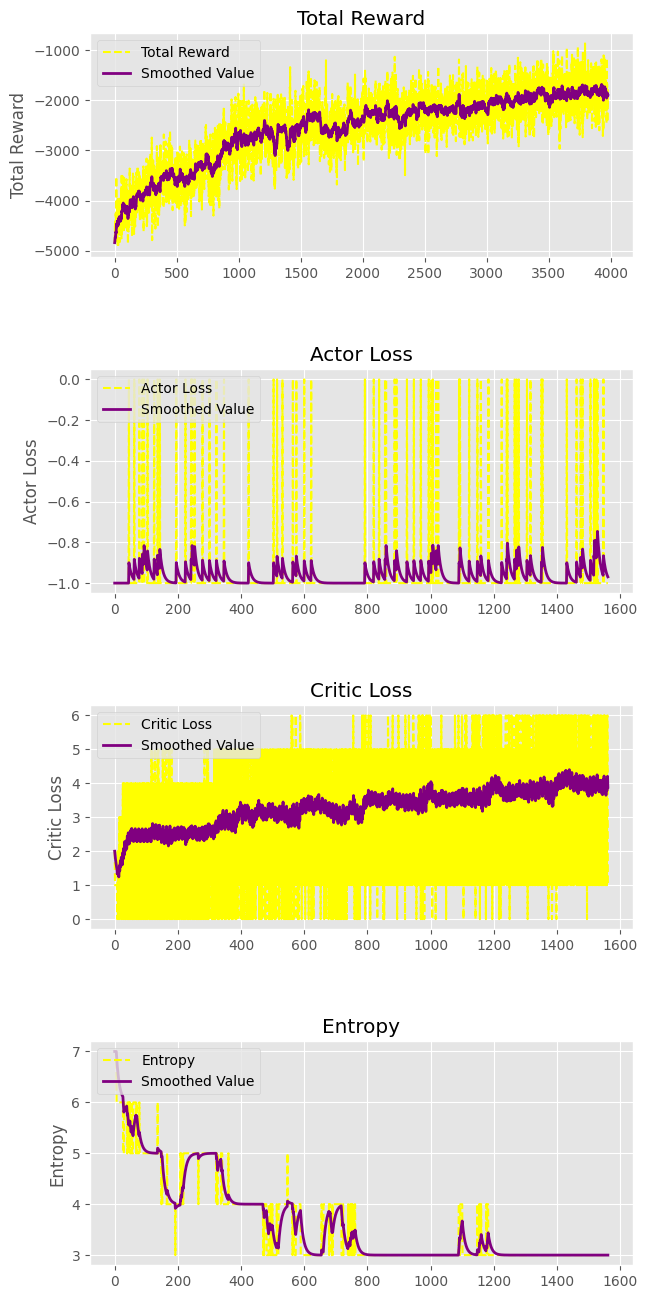

In [30]:
# Enable inline plotting
%matplotlib inline

# Initialize global step counter and reset the environment
global_step = 0
initial_state, _ = envs.reset()
state = torch.Tensor(initial_state).to(device)
done = torch.zeros(NUM_ENVS).to(device)

# Set up progress tracking
progress_bar = tqdm.tqdm(range(1, NUM_ITERATIONS + 1), postfix={'Total Rewards': 0})
actor_loss_history = []
critic_loss_history = []
entropy_objective_history = []

reward_history = []
episode_history = []

# Initialize the optimizer for the agent's parameters
optimizer = optim.Adam(agent.parameters(), lr=LEARNING_RATE, eps=1e-5)

for iteration in progress_bar:
    # Adjust the learning rate using a linear decay
    fraction_completed = 1.0 - (iteration - 1.0) / NUM_ITERATIONS
    current_learning_rate = fraction_completed * LEARNING_RATE
    optimizer.param_groups[0]["lr"] = current_learning_rate

    # Perform rollout to gather experience
    for step in range(0, ROLLOUT_STEPS):
        global_step += NUM_ENVS
        states[step] = state
        dones[step] = done

        with torch.no_grad():
            # Get action, log probability, and entropy from the agent
            action, log_probability, _ = agent.get_action_logprob_entropy(state)
            value = agent.get_value(state)
            values[step] = value.flatten()

        actions[step] = action
        logprobs[step] = log_probability

        # Execute action in the environment
        # next_state, reward, done, _, info = envs.step(action.cpu().numpy())
        next_state, reward, terminated, truncated, info = envs.step(action.cpu().numpy())
        done = np.logical_or(terminated, truncated)

        normalized_reward = (reward - min_reward) / (max_reward - min_reward)  # Normalize the reward
        rewards[step] = torch.tensor(normalized_reward).to(device).view(-1)
        state = torch.Tensor(next_state).to(device)
        done = torch.Tensor(done).to(device)


        if "final_info" in info:
            for i, ep_info in enumerate(info["final_info"]):
                if ep_info is not None and "episode" in ep_info:
                    episodic_reward = ep_info["episode"]["r"]
                    reward_history.append(episodic_reward)
                    episode_history.append(global_step)
                    progress_bar.set_postfix({'Total Rewards': episodic_reward})
        elif isinstance(info, dict) and "episode" in info:
            # finished envs mask
            mask = info.get("_episode", None)
            if mask is None:
                mask = info["episode"].get("_r", None)

            if mask is not None:
                # iterate over the finished envs and log their returns
                rs = np.asarray(info["episode"]["r"])
                for episodic_reward in rs[mask]:
                    episodic_reward = float(episodic_reward)
                    reward_history.append(episodic_reward)
                    episode_history.append(global_step)
                    progress_bar.set_postfix({'Total Rewards': episodic_reward})

    # Calculate advantages and returns
    with torch.no_grad():
        next_value = agent.get_value(state).reshape(1, -1)
        advantages = torch.zeros_like(rewards).to(device)

        last_gae_lambda = 0
        for t in reversed(range(ROLLOUT_STEPS)):
            if t == ROLLOUT_STEPS - 1:
                next_non_terminal = 1.0 - done
                next_value = next_value
            else:
                next_non_terminal = 1.0 - dones[t + 1]
                next_value = values[t + 1]

            # Compute delta using the utility function
            delta = get_deltas(rewards[t], values[t], next_value, next_non_terminal, gamma=GAMMA)

            advantages[t] = last_gae_lambda = delta + GAMMA * GAE_LAMBDA * next_non_terminal * last_gae_lambda
        returns = advantages + values

    # Flatten the batch data for processing
    batch_states = states.reshape((-1,) + envs.single_observation_space.shape)
    batch_logprobs = logprobs.reshape(-1)
    batch_actions = actions.reshape((-1,) + envs.single_action_space.shape)
    batch_advantages = advantages.reshape(-1)
    batch_returns = returns.reshape(-1)
    batch_values = values.reshape(-1)

    # Shuffle the batch data to break correlation between samples
    batch_indices = np.arange(BATCH_SIZE)
    total_actor_loss = 0
    total_critic_loss = 0
    total_entropy_objective = 0

    for epoch in range(NUM_EPOCHS):
        np.random.shuffle(batch_indices)
        for start in range(0, BATCH_SIZE, MINI_BATCH_SIZE):
            # Get the indices for the mini-batch
            end = start + MINI_BATCH_SIZE
            mini_batch_indices = batch_indices[start:end]

            mini_batch_advantages = batch_advantages[mini_batch_indices]
            # Normalize advantages to stabilize training
            mini_batch_advantages = (mini_batch_advantages - mini_batch_advantages.mean()) / (mini_batch_advantages.std() + 1e-8)

            # Compute new probabilities and values for the mini-batch
            new_probabilities = agent.get_probs(batch_states[mini_batch_indices])
            new_log_probability = agent.get_action_logprob(new_probabilities, batch_actions.long()[mini_batch_indices])
            entropy = agent.get_entropy(new_probabilities)
            new_value = agent.get_value(batch_states[mini_batch_indices])

            # Calculate the policy loss
            ratio = get_ratio(new_log_probability, batch_logprobs[mini_batch_indices])
            policy_objective = get_policy_objective(mini_batch_advantages, ratio, clip_coeff=CLIP_COEF)
            policy_loss = -policy_objective

            # Calculate the value loss
            value_loss = get_value_loss(new_value.view(-1), batch_values[mini_batch_indices], batch_returns[mini_batch_indices])

            # Calculate the entropy loss
            entropy_objective = get_entropy_objective(entropy)

            # Combine losses to get the total loss
            total_loss = get_total_loss(policy_objective, value_loss, entropy_objective, value_loss_coeff=VALUE_LOSS_COEF, entropy_coeff=ENTROPY_COEF)

            optimizer.zero_grad()
            total_loss.backward()
            # Clip the gradient to stabilize training
            nn.utils.clip_grad_norm_(agent.parameters(), 0.5)
            optimizer.step()

            total_actor_loss += policy_loss.item()
            total_critic_loss += value_loss.item()
            total_entropy_objective += entropy_objective.item()

    actor_loss_history.append(total_actor_loss // NUM_EPOCHS)
    critic_loss_history.append(total_critic_loss // NUM_EPOCHS)
    entropy_objective_history.append(total_entropy_objective // NUM_EPOCHS)

    # Prepare data for live plotting
    data_to_plot = {
        'Total Reward': reward_history,
        'Actor Loss': actor_loss_history,
        'Critic Loss': critic_loss_history,
        'Entropy': entropy_objective_history
    }
    live_plot(data_to_plot)

live_plot(data_to_plot, save_pdf=True, output_file='training_curves.pdf')
# Close the environment after training
envs.close()

Save the agent model by executing the code below.

In [31]:
torch.save(agent.state_dict(), "model.pth")

## Agent Evaluation

After training the agent, you can evaluate your agent using the following code.

In [32]:
env = create_elevator_env()

agent_test = ACAgent().to(device)

agent_test.load_state_dict(torch.load("model.pth", map_location=device))

num_episodes_to_run = 10
rewards = []

for episode in tqdm.tqdm(range(num_episodes_to_run)):
    total_reward = 0

    state, _ = env.reset()
    state = torch.tensor(state, dtype=torch.float32, device=device)
    while True:
        state_tensor = state

        with torch.no_grad():
            action, _, _ = agent_test.get_action_logprob_entropy(state_tensor)

        next_state, reward, terminated, truncated, info = env.step(action.cpu().item())
        done = np.logical_or(terminated, truncated)

        total_reward += reward

        state = torch.tensor(next_state, dtype=torch.float32, device=device)

        if done:
            break

    rewards.append(total_reward)

env.close()

print(f"\nMean Rewards: {np.mean(rewards)}\n")

/usr/local/lib/python3.12/dist-packages/pyRDDLGym/core/debug/exception.py:28: UserWarning: State invariant 1 does not have a structure of <action or state fluent> <op> <rhs>, where <op> is one of {<=, <, >=, >} and <rhs> is a deterministic function of non-fluents only, and will be ignored.
>> ( sum_{?f: floor} [ elevator-at-floor(?e, ?f) ] ) == 1
  warnings.warn(message)
100%|██████████| 10/10 [00:05<00:00,  1.91it/s]


Mean Rewards: -1910.025

